In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import datetime as dt
import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import anderson
from scipy import stats
from datetime import datetime

# <u> Créer un NOTEBOOK qui visera à analyser les ventes de la librairie LaPage. </u>
Le Notebook est constitué de 2 parties.
- Une analyse des différents indicateurs de vente, qui a été demandée directement par Antoine.
- Une analyse plus ciblée sur les clients demandée par Julie : l’objectif serait cette fois-ci de comprendre le comportement de clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques.

# SOMMAIRE


* [Introduction: Importation et traitement des DataFrames](#import)
* [PARTIE 1: Analyse demandée par Antoine](#partie1)
    * [A/ Indicateurs et graphiques sur le chiffre d'affaires ](#ca)
        * [1/ Chiffre d'affaires total ](#catotal)
        * [2/ Chiffre d'affaires par catégorie ](#cacateg)
        * [3/ Chiffre d'affaires par année et par mois](#caanmois)
        * [4/ Graphique du chiffre d'affaires (par âge)](#caagegraph)
        * [5/ Graphique de la frequence d'achat (par tranche âge)](#frequencegraph)
    * [B/ Évolution dans le temps et mise en place d'une décomposition en moyenne mobile pour évaluer la tendance globale ](#temps)
    * [C/ Analyse par réferences](#ref)
        * [1/ TOP 10 références par chiffre d'affaires ](#refflop)
        * [2/ FLOP 10 références par chiffre d'affaires ](#refflop)
    * [D/ Analyse par profils de clients](#customer)
        * [1/ TOP 10 clients en pourcentage du chiffre d'affaires](#customertop)
        * [2/ Courbe de Lorenz (par âge)](#lorenz)
* [PARTIE 2: Analyse demandée par Julie](#partie2)
    * [A/ Lien entre genre du client et les catégories de livres achetés](#casexe)
    * [B/ Lien entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés](#autres)
        * [1/ Lien entre l'âge des clients et le montant d'achat](#caage)
        * [2/ Lien entre l'âge des clients et la fréquence d'achat](#frequence)
        * [3/ Lien entre l'âge des clients et le panier moyen](#paniermoyen)
        * [4/ Lien entre l'âge des clients et les catégories achetées](#catage)

## Introduction: Importation et traitement des DataFrames </u> <a class="anchor" id="import"></a>

In [2]:
#importation des dataframes
customers = pd.read_csv('/Users/carloscorreawalasek/Desktop/OPENCLASSROOMS/DATA ANALYST/PROJETS/P6/Annexes Projet/Annexes Mission/DAN-P6-donnees/customers.csv')

products = pd.read_csv('/Users/carloscorreawalasek/Desktop/OPENCLASSROOMS/DATA ANALYST/PROJETS/P6/Annexes Projet/Annexes Mission/DAN-P6-donnees/products.csv')

transactions_2 = pd.read_csv('/Users/carloscorreawalasek/Desktop/OPENCLASSROOMS/DATA ANALYST/PROJETS/P6/Annexes Projet/Annexes Mission/DAN-P6-donnees/transactions.csv')

# à la suite du chemin du csv ajouter ",index_col == False"

In [3]:
products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [4]:
transactions_2.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


### SUPPRESSION DE TRANSACTIONS "TEST"

In [5]:
#Afficher les nombre de transactions "test"
transactions_2['date'].str.contains("test").value_counts()

False    679332
True        200
Name: date, dtype: int64

In [6]:
#Supprimer les transactions "test"
transactions_1 = transactions_2[~transactions_2['date'].astype(str).str.contains("test")].reset_index()

In [7]:
#Afficher les nombre de transactions "test" après suppression
transactions_1['date'].str.contains("test").value_counts()

False    679332
Name: date, dtype: int64

In [8]:
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [9]:
#ajouter une colonne 'âge'
year = datetime.now().year
customers['age'] = (year - customers['birth'])

### Détection d'un produit qui n'est pas référencé sur la table 'product' mais qui apparait dans la table 'transactions'

In [10]:
# Sélectionner les produits uniques dans la table des transactions
unique_products_in_transactions = set(transactions_1['id_prod'].unique())

# Sélectionner les produits uniques dans la table des produits
unique_products_in_products = set(products['id_prod'].unique())

# Trouver les produits uniques dans la table des transactions qui ne sont pas dans la table des produits
products_not_referenced = unique_products_in_transactions - unique_products_in_products

# Sélectionner toutes les lignes de transactions pour les produits non référencés
transactions_not_referenced = transactions_1[transactions_1['id_prod'].isin(products_not_referenced)]

# Afficher un produit qui n'est pas référencé, s'il y en a
if products_not_referenced:
    print("Le produit suivant est présent dans la table des transactions mais pas dans la table des produits :")
    print(products_not_referenced.pop())
else:
    print("Tous les produits dans la table des transactions sont référencés dans la table des produits.")
    
# Afficher les lignes de transactions pour les produits non référencés
transactions_not_referenced['id_prod'].str.contains("0_2245").value_counts()


Le produit suivant est présent dans la table des transactions mais pas dans la table des produits :
0_2245


True    221
Name: id_prod, dtype: int64

In [11]:
#Afficher les nombre de produits "0_2245"
transactions_1['id_prod'].str.contains("0_2245").value_counts()

False    679111
True        221
Name: id_prod, dtype: int64

In [12]:
#Supprimer la valeur non répértorié dans la df "products"
transactions = transactions_1[~transactions_1['id_prod'].astype(str).str.contains("0_2245")]

In [13]:
#Afficher les nombre de produits après suppression de "0_2245"
transactions['id_prod'].str.contains("0_2245").value_counts()

False    679111
Name: id_prod, dtype: int64

### JOINTURES DES TROIS TABLES

In [14]:
# affichage des colonnes de la DataFrame 'transactions'
print(transactions.columns)

# affichage des colonnes de la DataFrame 'products'
print(products.columns)

# jointure des dataframes 'transactions' et 'products' sur "id_prod"
df_1 = pd.merge(transactions, products, on='id_prod', how='left')

# suppression de la colonne index d'origine
df_1 = df_1.reset_index(drop=True)

# affichage des premières lignes de la DataFrame
df_1.head()

# jointure des dataframes 'transactions' et 'products' sur "id_prod"
df_1 = pd.merge(transactions[['id_prod', 'date', 'session_id', 'client_id']], 
                products[['id_prod', 'categ','price']], 
                on='id_prod', 
                how='left')

# affichage des premières lignes de la DataFrame
df_1.head()

Index(['index', 'id_prod', 'date', 'session_id', 'client_id'], dtype='object')
Index(['id_prod', 'price', 'categ'], dtype='object')


,id_prod,date,session_id,client_id,categ,price
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,0,4.18
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,1,15.99
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,0,7.99
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2,69.99
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,0,4.99


In [15]:
print(df_1.isnull().sum())

id_prod       0
date          0
session_id    0
client_id     0
categ         0
price         0
dtype: int64


In [16]:
#jointure des dataframes 'df_1' et 'customers'
df = pd.merge(df_1, customers, on='client_id', how= 'left')

#Suppression de la colonne index
df = df.reset_index(drop=True)

df.head()

,id_prod,date,session_id,client_id,categ,price,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,0,4.18,f,1986,37
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,1,15.99,m,1988,35
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,0,7.99,f,1968,55
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2,69.99,m,2000,23
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,0,4.99,m,1980,43


In [17]:
df.reset_index
df.head()

,id_prod,date,session_id,client_id,categ,price,sex,birth,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,0,4.18,f,1986,37
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,1,15.99,m,1988,35
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,0,7.99,f,1968,55
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2,69.99,m,2000,23
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,0,4.99,m,1980,43


In [18]:
print(df.isnull().sum())

id_prod       0
date          0
session_id    0
client_id     0
categ         0
price         0
sex           0
birth         0
age           0
dtype: int64


In [19]:
df.dtypes

id_prod        object
date           object
session_id     object
client_id      object
categ           int64
price         float64
sex            object
birth           int64
age             int64
dtype: object

In [20]:
# Convertir la colonne 'date' en format datetime
df['date'] = pd.to_datetime(df['date'])

#Créer une colonne "mois_année" et une colonne "année"
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
df['year'] = pd.to_datetime(df['date']).dt.to_period('Y')

#voir les données maximales et minimales pour la variable de "date"
for var in ["month_year"]:
    print('Pour la variable ', var)
    print('Maximum : ', df[var].max())
    print('Minimum : ', df[var].min())
    
df

Pour la variable  month_year
Maximum :  2023-02
Minimum :  2021-03


,id_prod,date,session_id,client_id,categ,price,sex,birth,age,month_year,year
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,0,4.18,f,1986,37,2022-05,2022
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,1,15.99,m,1988,35,2022-02,2022
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,0,7.99,f,1968,55,2022-06,2022
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2,69.99,m,2000,23,2021-06,2021
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,0,4.99,m,1980,43,2023-01,2023
...,...,...,...,...,...,...,...,...,...,...,...
679106,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,0,12.99,f,1951,72,2022-01,2022
679107,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,1,10.99,f,1977,46,2022-03,2022
679108,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,0,12.99,f,1988,35,2022-12,2022
679109,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,0,4.98,m,1986,37,2021-07,2021


In [21]:
#voir les données maximales et minimales pour la variable de "age"
for var in ["age"]:
    print('Pour la variable ', var)
    print('Maximum : ', df[var].max())
    print('Minimum : ', df[var].min())
    
df

Pour la variable  age
Maximum :  94
Minimum :  19


,id_prod,date,session_id,client_id,categ,price,sex,birth,age,month_year,year
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,0,4.18,f,1986,37,2022-05,2022
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,1,15.99,m,1988,35,2022-02,2022
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,0,7.99,f,1968,55,2022-06,2022
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2,69.99,m,2000,23,2021-06,2021
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,0,4.99,m,1980,43,2023-01,2023
...,...,...,...,...,...,...,...,...,...,...,...
679106,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489,0,12.99,f,1951,72,2022-01,2022
679107,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370,1,10.99,f,1977,46,2022-03,2022
679108,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304,0,12.99,f,1988,35,2022-12,2022
679109,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227,0,4.98,m,1986,37,2021-07,2021


In [22]:
# Définir les limites de chaque tranche d'âge
bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]

# Définir les étiquettes de chaque tranche d'âge
labels = ['19-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

# Créer la colonne "Tranche d'âge" dans le dataframe customers
df['Range_of_age'] = pd.cut(df['age'], bins=bins, labels=labels)

# Afficher les premières lignes du dataframe customers avec la nouvelle colonne "Tranche d'âge"
df.head()

,id_prod,date,session_id,client_id,categ,price,sex,birth,age,month_year,year,Range_of_age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,0,4.18,f,1986,37,2022-05,2022,30-39
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,1,15.99,m,1988,35,2022-02,2022,30-39
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,0,7.99,f,1968,55,2022-06,2022,50-59
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941,2,69.99,m,2000,23,2021-06,2021,19-29
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232,0,4.99,m,1980,43,2023-01,2023,40-49


# PARTIE 1: Analyse demandée par Antoine </u> <a class="anchor" id="partie1"></a>

### A/ Indicateurs et graphiques sur le chiffre d'affaires </u> <a class="anchor" id="ca"></a>

#### 1/ Chiffre d'affaires total </u> <a class="anchor" id="catotal"></a>

In [23]:
#calcul du chiffre d'affaires total (sommer toutes les cellules de la colonne 'price')
ca = sum(df['price'])
print("Le chiffre d'affaires total est de", ca, "€")

Le chiffre d'affaires total est de 11853728.680061746 €


#### 2/ Chiffre d'affaires par catégorie </u> <a class="anchor" id="cacateg"></a>

In [24]:
#agréger les transactions par catégorie
sales_by_cat = df.groupby(['categ'], as_index=False)['price'].sum()
sales_by_cat.head()

,categ,price
0,0,4419730.97
1,1,4653722.69
2,2,2780275.02


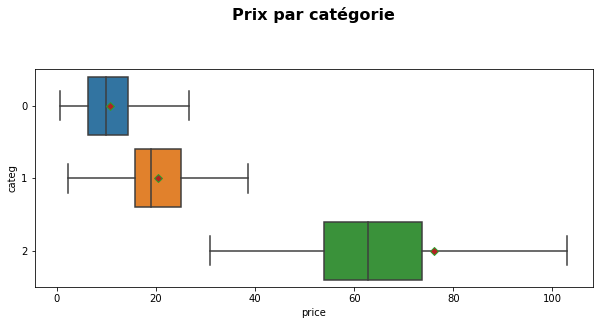

In [25]:
# Distribution et moyenne des prix par catégorie
plt.figure(figsize=(10,4))
sns.boxplot(data=df, y='categ', x='price', orient='h', showfliers=False, showmeans=True, meanprops={"marker":"D","markerfacecolor":"firebrick"})
plt.title('Prix par catégorie', fontsize=16, y=1.2, weight='bold')
plt.show()

In [26]:
#créer une table de contingence
df_ca_date = pd.DataFrame(df.groupby([df['date'].dt.to_period('M'),'categ'])['price'].sum())
df_ca_date.head()

price
date    categ           
2021-03 0      193629.17
        1      186974.17
        2      101837.27
2021-04 0      205222.46
        1      156138.35

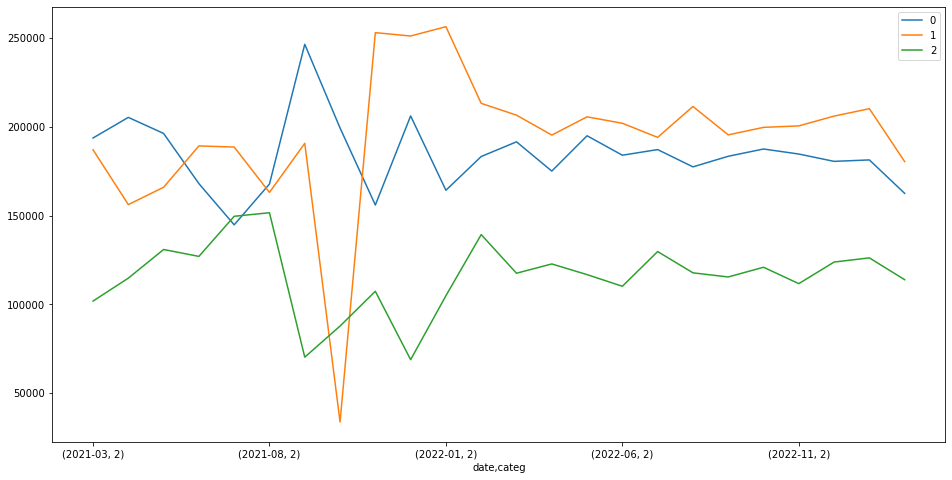

In [27]:
#représenter graphiquement l'évolution des ventes par catégorie
df_ca_date.groupby('categ')['price'].plot(legend=True, figsize=(16, 8))
plt.show()

### Dans le mois d'Octobre, la catégorie 1 n'a pas comptabilisé de ventes

#### 3/ Chiffre d'affaires par année et par mois </u> <a class="anchor" id="caanmois"></a>

### PAR ANNÉE

In [28]:
#agréger les transactions par année
sales_by_year = df.groupby(['year'], as_index=False)['price'].sum()
sales_by_year.head()

,year,price
0,2021,4770826.56
1,2022,6108681.81
2,2023,974220.31


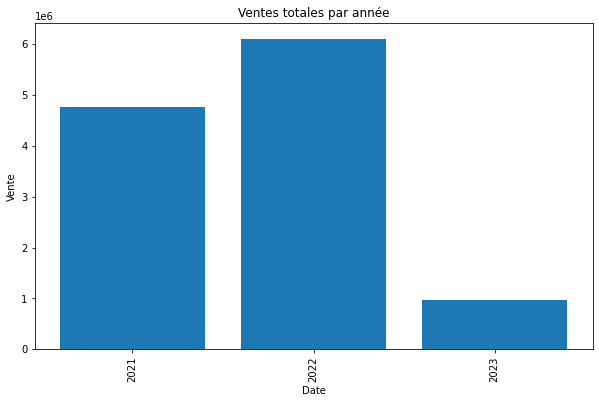

In [29]:
#graphique des ventes par année
sales_by_year['year'] = sales_by_year['year'].dt.strftime('%Y')

plt.figure(figsize=(10,6))
plt.bar(sales_by_year['year'], sales_by_year['price'])
plt.xlabel('Date')
plt.ylabel('Vente')
plt.title('Ventes totales par année')
plt.xticks(rotation=90)
plt.show()

### PAR MOIS

In [30]:
#agréger les transactions par année
sales_by_month = df.groupby(['month_year'], as_index=False)['price'].sum()
sales_by_month.head()

,month_year,price
0,2021-03,482440.61
1,2021-04,476109.30
2,2021-05,492943.47
3,2021-06,484088.56
4,2021-07,482835.40


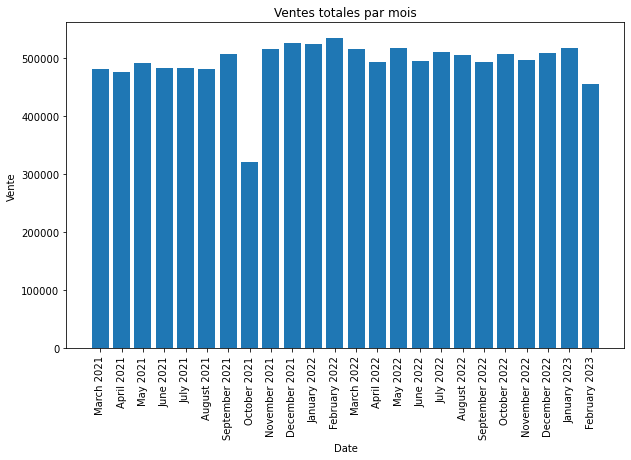

In [31]:
#graphique des ventes par mois
sales_by_month['month_year'] = sales_by_month['month_year'].dt.strftime('%B %Y')

plt.figure(figsize=(10,6))
plt.bar(sales_by_month['month_year'], sales_by_month['price'])
plt.xlabel('Date')
plt.ylabel('Vente')
plt.title('Ventes totales par mois')
plt.xticks(rotation=90)
plt.show()

#### 4/ Graphique du chiffre d'affaires (par tranche âge) </u> <a class="anchor" id="caagegraph"></a>

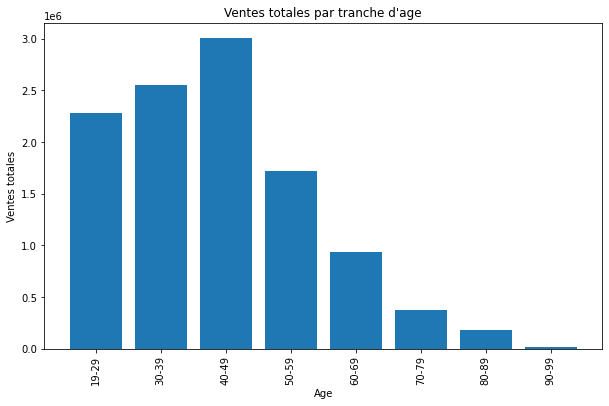

In [32]:
#graphique de ventes par tranche d'âge
sales_by_age = df.groupby(['Range_of_age'], as_index=False)['price'].sum()

plt.figure(figsize=(10, 6))
plt.bar(sales_by_age['Range_of_age'], sales_by_age['price'])
plt.xlabel('Age')
plt.ylabel('Ventes totales')
plt.title('Ventes totales par tranche d\'age')
plt.xticks(rotation=90)
plt.show()

#### 5/ Graphique de la frequence d'achat (par tranche âge) </u> <a class="anchor" id="frequencegraph"></a>

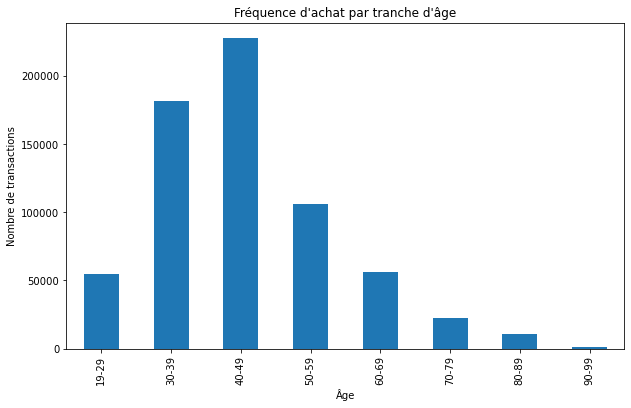

In [33]:
# Calcul de la fréquence d'achat par âge
freq_achat_par_age = df.groupby('Range_of_age')['id_prod'].count()

# Affichage de la fréquence d'achat par âge sur un graphique
freq_achat_par_age.plot(kind='bar', figsize=(10, 6))
plt.title("Fréquence d'achat par tranche d'âge")
plt.xlabel("Âge")
plt.ylabel("Nombre de transactions")
plt.show()

### B/ Évolution dans le temps et mise en place d'une décomposition en moyenne mobile pour évaluer la tendance globale </u> <a class="anchor" id="temps"></a>

TOUTES LES TRANSACTIONS DE CAT 1 n'exsitent pas sur la periode d'OCTOBRE.
Tracer les ventes (sous forme de coubre) par catégorie dans le temps pour visualiser le manque en OCT

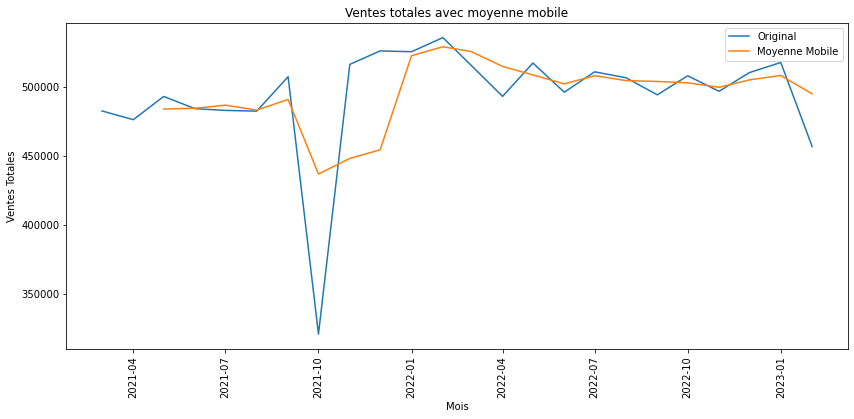

In [34]:
#faire un graphique représentant la moyenne mobile
sales_by_month['month_year'] = pd.to_datetime(sales_by_month['month_year'])
new_df = sales_by_month.set_index('month_year')
rolling_mean = new_df['price'].rolling(window=3).mean()

plt.figure(figsize=(14,6))
plt.plot(new_df['price'], label='Original')
plt.plot(rolling_mean, label='Moyenne Mobile')
plt.xlabel('Mois')
plt.ylabel('Ventes Totales')
plt.title('Ventes totales avec moyenne mobile')
plt.legend()
plt.xticks(rotation=90)
plt.show()

### La moyenne mobile est faite pour faire des prévisions en éliminant les saisonnalités. C'est une moyenne glissante dans le temps

### C/ Analyse par références </u> <a class="anchor" id="ref"></a>

#### 1/ TOP 10 références par chiffre d'affaires </u> <a class="anchor" id="reftop"></a>

In [35]:
#agréger les transactions par référence
sales_by_ref = df.groupby(['id_prod'], as_index=False)['price'].sum()

#TOP 10 des transactions par référence
sales_by_ref.sort_values(by='price', ascending=False).head(10)

,id_prod,price
3096,2_159,94893.50
3070,2_135,69334.95
3045,2_112,65407.76
3034,2_102,60736.78
3152,2_209,56971.86
2619,1_395,54356.25
2591,1_369,54025.48
3043,2_110,53846.25
3201,2_39,53060.85
3104,2_166,52449.12


#### 2/ FLOP 10 références par chiffre d'affaires </u> <a class="anchor" id="refflop"></a>

In [36]:
#FLOP 10 des transactions par référence
sales_by_ref.sort_values(by='price', ascending=True).head(10)

,id_prod,price
595,0_1539,0.99
313,0_1284,1.38
719,0_1653,1.98
665,0_1601,1.99
2079,0_807,1.99
1784,0_541,1.99
802,0_1728,2.27
549,0_1498,2.48
2179,0_898,2.54
925,0_1840,2.56


### D/ Analyse par profils de clients </u> <a class="anchor" id="customer"></a>

#### 1/ TOP 10 clients en pourcentage du chiffre d'affaires </u> <a class="anchor" id="customertop"></a>

In [37]:
#chiffre d'affaires par client
df_conso = df.groupby(['client_id'])['price'].sum().reset_index()
df_conso.rename(columns = {'price':"Chiffre d'affaires"}, inplace= True)
df_conso['Pourcentage'] = round((df_conso["Chiffre d'affaires"])/(df_conso["Chiffre d'affaires"].sum())*100, 2)
df_conso.sort_values(by="Pourcentage",ascending=False).head(10)

,client_id,Chiffre d'affaires,Pourcentage
677,c_1609,324033.35,2.73
4388,c_4958,289760.34,2.44
6337,c_6714,153598.92,1.30
2724,c_3454,113637.93,0.96
268,c_1240,4225.63,0.04
915,c_1823,4558.32,0.04
992,c_1893,4525.07,0.04
973,c_1876,4970.62,0.04
6639,c_699,4200.07,0.04
852,c_1767,4481.90,0.04


In [38]:
#nouvelle dataframe avec les données du df 'df_age' et les données du df 'customers' avec comme clé primaire 'client_id'
df_age = pd.merge(df_conso, customers, how='left', on=['client_id'])
df_age

,client_id,Chiffre d'affaires,Pourcentage,sex,birth,age
0,c_1,558.18,0.00,m,1955,68
1,c_10,1353.60,0.01,m,1956,67
2,c_100,254.85,0.00,m,1992,31
3,c_1000,2261.89,0.02,f,1966,57
4,c_1001,1812.86,0.02,m,1982,41
...,...,...,...,...,...,...
8595,c_995,189.41,0.00,m,1955,68
8596,c_996,1625.58,0.01,f,1970,53
8597,c_997,1490.01,0.01,f,1994,29
8598,c_998,2779.88,0.02,m,2001,22


In [39]:
#créer une colonne 'total ventes' et une colonne 'ventes mensuelles'
df['date_fixe'] = df['date'].dt.date 
df = df.merge(df.groupby('client_id').count()['date'].reset_index().rename(columns={'date': 'total_ventes'}), how='left', on='client_id')
df['ventes_mensuelles'] = round(df['total_ventes'] / 12)
df.sort_values(by='client_id')

,id_prod,date,session_id,client_id,categ,price,sex,birth,age,month_year,year,Range_of_age,date_fixe,total_ventes,ventes_mensuelles
449848,0_1571,2022-07-01 01:47:04.355850,s_231729,c_1,0,5.99,m,1955,68,2022-07,2022,60-69,2022-07-01,39,3.0
542680,0_1547,2022-05-08 08:27:49.586711,s_205377,c_1,0,8.99,m,1955,68,2022-05,2022,60-69,2022-05-08,39,3.0
169172,0_1475,2022-06-27 10:30:00.293075,s_230001,c_1,0,11.99,m,1955,68,2022-06,2022,60-69,2022-06-27,39,3.0
318801,0_1880,2021-11-04 18:37:01.482109,s_114737,c_1,0,14.91,m,1955,68,2021-11,2021,60-69,2021-11-04,39,3.0
583828,0_1090,2021-12-19 02:44:12.827475,s_136532,c_1,0,13.78,m,1955,68,2021-12,2021,60-69,2021-12-19,39,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308937,0_1442,2023-01-28 13:12:42.429052,s_333631,c_999,0,4.89,m,1964,59,2023-01,2023,50-59,2023-01-28,46,4.0
235560,1_395,2021-08-23 16:44:27.072834,s_79695,c_999,1,28.99,m,1964,59,2021-08,2021,50-59,2021-08-23,46,4.0
92930,0_1426,2021-09-10 02:44:13.556163,s_87567,c_999,0,13.44,m,1964,59,2021-09,2021,50-59,2021-09-10,46,4.0
385190,0_2104,2021-10-02 20:31:58.645109,s_99070,c_999,0,7.98,m,1964,59,2021-10,2021,50-59,2021-10-02,46,4.0


In [40]:
df.describe()

,categ,price,birth,age,total_ventes,ventes_mensuelles
count,679111.000000,679111.000000,679111.000000,679111.000000,679111.000000,679111.000000
mean,0.441953,17.454773,1977.811149,45.188851,1314.735478,109.560590
std,0.595042,18.328998,13.575361,13.575361,4947.838568,412.316528
min,0.000000,0.620000,1929.000000,19.000000,1.000000,0.000000
25%,0.000000,8.870000,1970.000000,36.000000,65.000000,5.000000
50%,0.000000,13.990000,1980.000000,43.000000,123.000000,10.000000
75%,1.000000,18.990000,1987.000000,53.000000,224.000000,19.000000
max,2.000000,300.000000,2004.000000,94.000000,25488.000000,2124.000000


In [41]:
#créer une nouvelle table pour créer une colonne 'panier moyen' par client
new_df = pd.merge(df_age, df[['client_id','total_ventes','ventes_mensuelles']], how='left', on=['client_id'])
new_df['panier_moyen']=round((new_df["Chiffre d'affaires"]/new_df['total_ventes']),2)
new_df.drop_duplicates(inplace=True)
new_df.head()

,client_id,Chiffre d'affaires,Pourcentage,sex,birth,age,total_ventes,ventes_mensuelles,panier_moyen
0,c_1,558.18,0.00,m,1955,68,39,3.0,14.31
39,c_10,1353.60,0.01,m,1956,67,58,5.0,23.34
97,c_100,254.85,0.00,m,1992,31,8,1.0,31.86
105,c_1000,2261.89,0.02,f,1966,57,125,10.0,18.10
230,c_1001,1812.86,0.02,m,1982,41,102,8.0,17.77


#### 2/ Courbe de Lorenz </u> <a class="anchor" id="lorenz"></a>

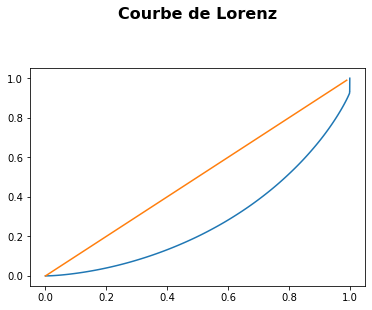

Indice de Gini : 0.44638654137401435


In [42]:
#définir les valeurs à intégrer dans le graphique
depenses = new_df[new_df["Chiffre d'affaires"] > 0]
dep = depenses["Chiffre d'affaires"].values
n = len(dep)

#Calculer les fréquences cumulées de "price"
lorenz = np.cumsum(np.sort(dep)) / dep.sum()

#La courbe de Lorenz commence à 0
lorenz = np.append([0],lorenz)

#Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0.
xaxis = np.linspace(0-1/n,1+1/n,n+1) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
a = np.arange(0,1,.01)
x = a
y = a  
sns.lineplot(x=x,y=y)
plt.title('Courbe de Lorenz', fontsize=16, y=1.2, weight='bold')
plt.show()
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz(Area Under the Curve). Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # Surface entre la première bissectrice et la courbe de Lorenz
gini = 2*S
print('Indice de Gini :', gini)

#### L'indice es plus proche de 0 si la distribution est equilibré, plus proche de 1 s'il est inégalitaire.
la courbe en orange étant la ligne d'égalité ou de parité

# PARTIE 2: Analyse demandée par Julie </u> <a class="anchor" id="partie2"></a>

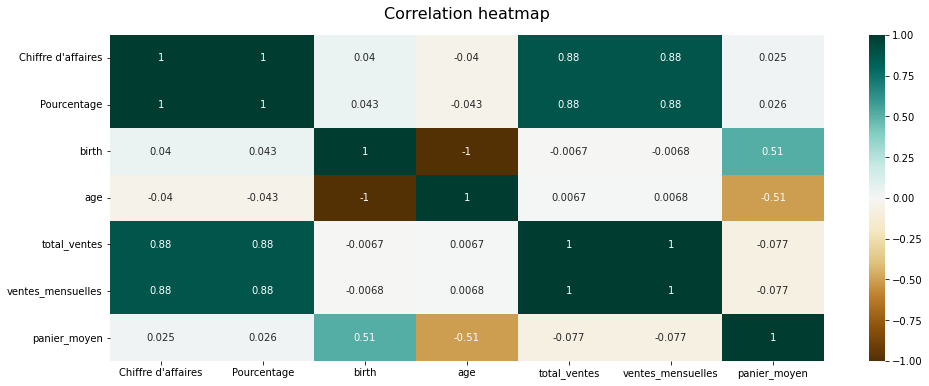

In [43]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(new_df.corr(), ax=ax, annot=True, cmap='BrBG')
plt.title('Correlation heatmap', fontdict={'fontsize':16}, pad=16)
plt.show()

#### Le p-value est un indicateur important car il permet de déterminer si une corrélation ou une différence entre les moyennes observées dans les données est statistiquement significative ou non. 

#### La valeur de 0,05 est généralement utilisée comme seuil de significativité. 
#### Si le p-value est inférieur à 0,05, cela signifie qu'il y a une forte probabilité que la corrélation ou la différence observée ne soit pas due au hasard, mais plutôt à une véritable relation entre les variables ou à une différence entre les groupes.

### A/ Lien entre genre du client et les catégories de livres achetés </u> <a class="anchor" id="casexe"></a>

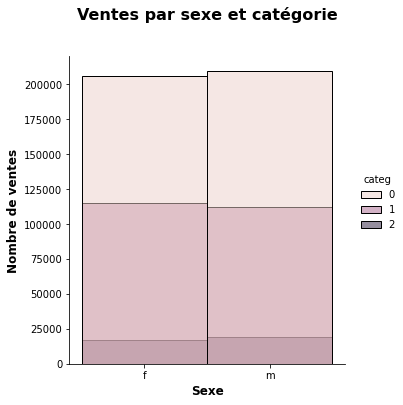

In [44]:
sns.displot(data=df, x='sex', hue='categ')
plt.title('Ventes par sexe et catégorie', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Nombre de ventes",fontsize=12, weight='bold')
plt.xlabel('Sexe',fontsize=12, weight='bold')
plt.show()

In [45]:
#Création d'un tableau croisé des catégories de livres par sexe
contingency_table = pd.crosstab(df["sex"], df["categ"])

# Affichage du tableau de contingence
print(contingency_table)

# Test du chi2 d'indépendance entre les variables sexe et catégorie de livre
chi2, pval, dof, expected = st.chi2_contingency(contingency_table)

# Affichage du résultat du test
print("Test de Chi2 d'indépendance entre le sexe et la catégorie de livre :")
print("Valeur de Chi2 = ", chi2)
print("P-value = ", pval)

categ       0       1      2
sex                         
f      206103  114899  17283
m      209356  112270  19200
Test de Chi2 d'indépendance entre le sexe et la catégorie de livre :
Valeur de Chi2 =  147.11906816131497
P-value =  1.1310980597090762e-32


#### La valeur de Chi2 est élevée : 147.119 -> Cela suggère qu'il existe une dépendance significative entre le sexe et la catégorie de livre.

#### La valeur p-value est très faible : 1.13e-32. -> Cela indique qu'il y a une corrélation statistiquement significative entre les deux variables.

### B/ Lien entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés </u> <a class="anchor" id="autres"></a>

#### 1/ Lien entre l'âge des clients et le montant d'achat </u> <a class="anchor" id="caage"></a>

#### ANOVA / Kruskall-Wallis

In [46]:
#Test d'ANOVA pour distribution normale
myNom = new_df['age']
myScale = new_df["Chiffre d'affaires"]

myCat1 = myNom <= 31
myCat2 = myNom.between(32,51)
myCat3 = myNom >=52

myCatScores1 =myScale[myCat1].dropna()
myCatScores2 =myScale[myCat2].dropna()
myCatScores3 =myScale[myCat3].dropna()

stat, p =f_oneway(myCatScores1, myCatScores2, myCatScores3)
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


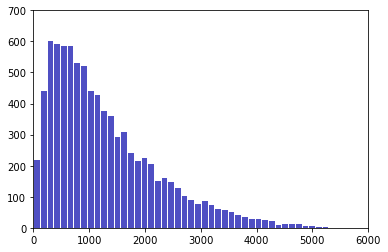

In [47]:
plt.hist(x=new_df["Chiffre d'affaires"], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.xlim(0, 6000)
plt.ylim(0, 700)
plt.show()

In [48]:
#Test de normalité
anderson(new_df["Chiffre d'affaires"], dist='norm')

AndersonResult(statistic=2139.4683085598554, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#### Résultat non-paramétrique (les données ne suivent pas une distribution normale)

In [49]:
#Test de Kruskal-Wallis pour variables non-paramétriques
stat, p =st.kruskal(myCatScores1 , myCatScores2, myCatScores3)
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


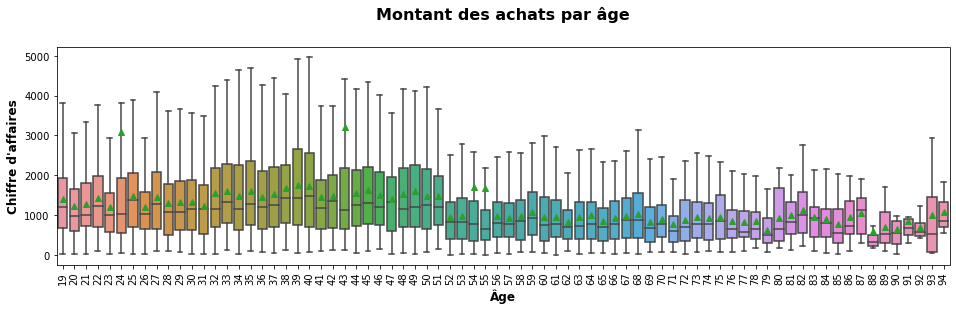

In [50]:
#représentation graphique du chiffre d'affaires par âge
plt.figure(figsize=(16,4))
sns.boxplot(
    data=new_df.pivot_table(index=['client_id']),
    y="Chiffre d'affaires", x='age', showfliers=False, showmeans=True)
plt.xticks(rotation=90)
plt.title("Montant des achats par âge", fontsize=16, y=1.1, weight='bold')
plt.ylabel("Chiffre d'affaires",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

Validation de H1: Une ou plusieurs des moyennes des échantillons sont inégales. (p> 0.05)

 #### 2/ Lien entre l'âge des clients et la fréquence d'achat </u> <a class="anchor" id="frequence"></a>

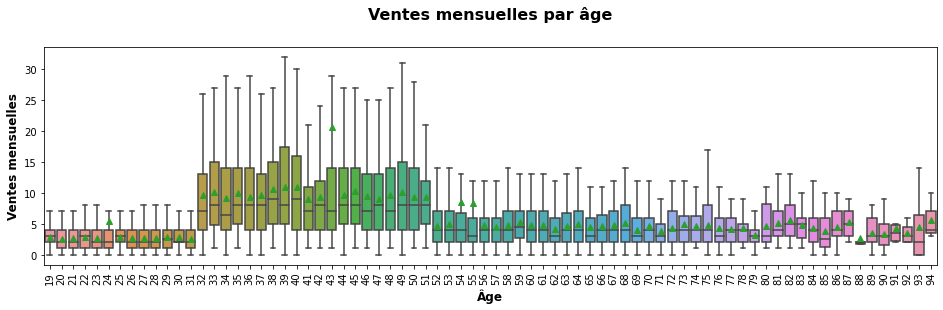

In [51]:
plt.figure(figsize=(16,4))
sns.boxplot(
    data=new_df.pivot_table(index=['client_id']),
    y='ventes_mensuelles', x='age', showfliers=False, showmeans=True)
plt.xticks(rotation=90)
plt.title('Ventes mensuelles par âge', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Ventes mensuelles",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

In [52]:
#Test de normalité
anderson(new_df["ventes_mensuelles"], dist='norm')

AndersonResult(statistic=2073.2872941553924, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#### Résultat non-paramétrique (les données ne suivent pas une distribution normale)

In [53]:
#Test de Kruskal-Wallis pour variables non-paramétriques
myNom = new_df['age']
myScale = new_df["ventes_mensuelles"]

myCat1 = myNom <= 31
myCat2 = myNom.between(32,51)
myCat3 = myNom >=52

myCatScores1 =myScale[myCat1].dropna()
myCatScores2 =myScale[myCat2].dropna()
myCatScores3 =myScale[myCat3].dropna()
stat, p = st.kruskal(myCatScores1 , myCatScores2, myCatScores3)
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


#### 3/ Lien entre l'âge des clients et le panier moyen </u> <a class="anchor" id="paniermoyen"></a>

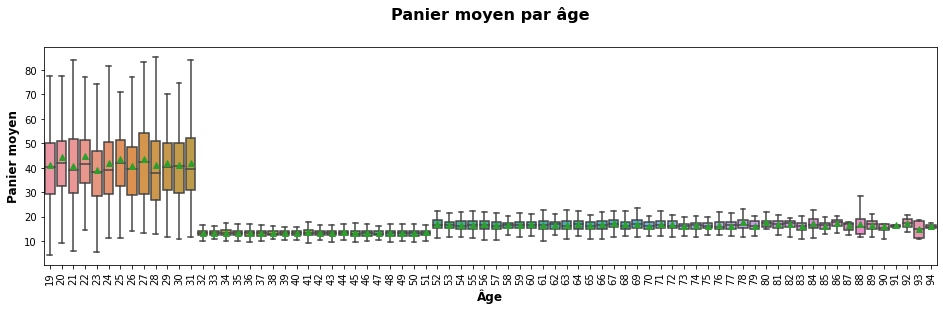

In [54]:
#Graphique
plt.figure(figsize=(16,4))
sns.boxplot(
    data=new_df.pivot_table(index=['client_id']),
    y='panier_moyen', x='age', showfliers=False, showmeans=True)
plt.xticks(rotation=90)
plt.title('Panier moyen par âge', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Panier moyen",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

In [55]:
#Test de normalité
anderson(new_df["panier_moyen"], dist='norm')

AndersonResult(statistic=1003.7108181668318, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#### Résultat non-paramétrique (les données ne suivent pas une distribution normale)

In [56]:
#Test de Kruskal-Wallis pour variables non-paramétriques
myNom = new_df['age']
myScale = new_df["panier_moyen"]

myCat1 = myNom <= 31
myCat2 = myNom.between(32,51)
myCat3 = myNom >=52

myCatScores1 =myScale[myCat1].dropna()
myCatScores2 =myScale[myCat2].dropna()
myCatScores3 =myScale[myCat3].dropna()
stat, p = st.kruskal(myCatScores1 , myCatScores2, myCatScores3)
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


#### 4/ Lien entre l'âge des clients et les catégories achetées </u> <a class="anchor" id="catage"></a>

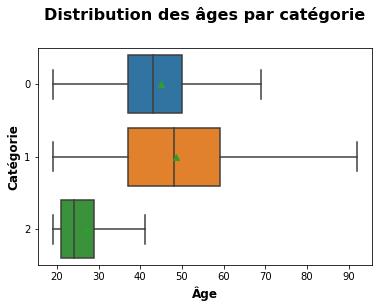

In [57]:
#représentation graphique plot
sns.boxplot(data=df, x='age', y='categ', orient='h', showfliers=False, showmeans=True)
plt.title('Distribution des âges par catégorie', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Catégorie",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

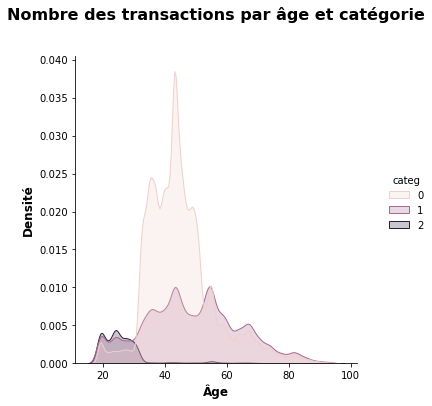

In [58]:
#Graphique
sns.displot(data=df, x='age', hue='categ', kind='kde', fill=True)
plt.title('Nombre des transactions par âge et catégorie', fontsize=16, y=1.1, weight='bold')
plt.ylabel("Densité",fontsize=12, weight='bold')
plt.xlabel('Âge',fontsize=12, weight='bold')
plt.show()

In [59]:
#Test de normalité
anderson(df["age"], dist='norm')

AndersonResult(statistic=5027.318051605951, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#### Résultat non-paramétrique (les données ne suivent pas une distribution normale)

In [60]:
#Test de Kruskal-Wallis pour variables non-paramétriques
myNom = df['age']
myScale = df["categ"]

myCat1 = myNom <= 31
myCat2 = myNom.between(32,51)
myCat3 = myNom >=52

myCatScores1 =myScale[myCat1].dropna()
myCatScores2 =myScale[myCat2].dropna()
myCatScores3 =myScale[myCat3].dropna()
stat, p = st.kruskal(myCatScores1 , myCatScores2, myCatScores3)
if p > .05:
    print('H0: Les moyennes des groupes son égales')
else:
    print('H1: Une ou plusieurs des moyennes des échantillons sont inégales')

H1: Une ou plusieurs des moyennes des échantillons sont inégales


## Conclusions: 
#### Ces résultats suggèrent que l'âge des clients est un facteur important à considérer lorsqu'on analyse le comportement d'achat de livres. 
#### Les clients plus jeunes ont tendance à dépenser plus en montant total d'achat, mais moins fréquemment et avec un panier moyen plus petit.
#### En outre, les différences entre les catégories de livres achetés montrent qu'il peut être intéressant de personnaliser les offres et les promotions en fonction de l'âge des clients et de leurs préférences en matière de livres.